In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tools._graphtools import createGT

In [3]:
p = 2
d = 7
X =[2,3,2]#[p]*d

gt = createGT(X)

In [4]:
def format_counter(counter):

    """Formats A Counter Objects for Easy Step Plotting"""
    # Example: a counter whose keys are numeric values (e.g. eigenvalues)
    total = sum(counter.values())

    # Sort keys in ascending order (or in any desired order)
    keys = sorted(counter.keys())

    # Compute the fraction of the total for each key
    fractions = [counter[k] / total for k in keys]

    # Compute cumulative boundaries along x: start at 0 and add each fraction
    cum = np.concatenate(([0], np.cumsum(fractions)))

    x_steps = []
    y_steps = []
    for i, k in enumerate(keys):
        x_steps.extend([cum[i], cum[i+1]])
        y_steps.extend([k, k])

    return (x_steps,y_steps)

def butterfly(gt, phi_array,tol=6):
    counter_arr = []

    for phi in phi_array:
        H_eigs = np.linalg.eigvalsh(gt.weighted_adj(phi))
        eig_counter = Counter()
        for eig in H_eigs:
            eig_counter[np.round(eig,decimals=tol)] += 1
        counter_arr.append(eig_counter)
    return counter_arr

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

In [5]:
phi_bins=int(5e4)

#phis = np.linspace(-np.pi,np.pi,phi_bins)
phis= np.linspace(0,2*np.pi,phi_bins)
Nbin = int(5e4)
energy_bins = np.linspace(-p-1, p+1, Nbin)
delta = 2*p/(Nbin-1)

counters = butterfly(gt, phis)
binned_counters = []

for counter in counters:
    e_bin_curr = energy_bins
    last_idx = 0
    binned_counter = np.zeros(Nbin)

    for element, count in counter.items():
        bin_e, curr_idx = find_nearest(e_bin_curr,element)
        e_bin_curr = e_bin_curr[curr_idx:]
        binned_counter[last_idx+curr_idx] = counter[element]
        last_idx +=curr_idx
    binned_counters.append(binned_counter)


: 

: 

In [45]:
max(energy_bins)

np.float64(3.0)

In [46]:
def plot_binned_counters_heatmap(binned_counters, energy_bins, phis,
                                 vmin=1, vmax=10, cmap_name="viridis",
                                 ylabel="Energy", xlabel=r"$\phi$",
                                 rebin_factor=1):
    """
    Heat-map of binned_counters with white background for zeros.
    
    Can optionally re-bin the data by a specified factor.
    
    Parameters
    ----------
    binned_counters : 2-D array  (#phis × #energy_bins)
    energy_bins     : 1-D array (centres OR edges) for the X axis
    phis            : 1-D array (centres OR edges) for the Y axis
    vmin            : lowest value shown on the colour scale (default 1)
    cmap_name       : Matplotlib colormap to start from (default 'viridis')
    rebin_factor    : int
                      Factor to bin data together. e.g., rebin_factor=2
                      will combine 2x2 bins into a single bin (by summing).
                      Defaults to 1 (no re-binning).
    """

    # --- New Re-binning Logic ---
    # Make copies to avoid modifying the original arrays
    data_in = binned_counters.copy()
    ebins_in = energy_bins.copy()
    phis_in = phis.copy()
    
    f = int(rebin_factor)
    
    if f > 1:
        # 1. Get original shape and determine if we're using edges or centers
        ny, nx = data_in.shape
        is_edges = (ebins_in.size == nx + 1) and (phis_in.size == ny + 1)
        
        # 2. Calculate new dimensions, trimming any excess bins
        ny_new = (ny // f)
        nx_new = (nx // f)
        
        # Trim data array to be divisible by the factor
        data_trimmed = data_in[:ny_new * f, :nx_new * f]
        
        # 3. Reshape and sum to create the new binned data
        # Reshapes to (ny_new, f, nx_new, f) then sums over axes 1 and 3 (the 'f' dimensions)
        binned_counters = data_trimmed.reshape(ny_new, f, nx_new, f).sum(axis=(1, 3))

        # 4. Re-bin the axes arrays
        if is_edges:
            # For edges, we just select every 'f'-th edge
            # Trim edge arrays to match the trimmed data shape (+1)
            phis_trimmed = phis_in[:ny_new * f + 1]
            ebins_trimmed = ebins_in[:nx_new * f + 1]
            
            phis = phis_trimmed[::f]
            energy_bins = ebins_trimmed[::f]
        else:
            # For centers, we average the centers of the combined bins
            # Trim center arrays to match the trimmed data shape
            phis_trimmed = phis_in[:ny_new * f]
            ebins_trimmed = ebins_in[:nx_new * f]
            
            # Reshape and average
            phis = phis_trimmed.reshape(ny_new, f).mean(axis=1)
            energy_bins = ebins_trimmed.reshape(nx_new, f).mean(axis=1)
    elif f < 1:
        raise ValueError("rebin_factor must be >= 1")
    # --- End of Re-binning Logic ---


    # 1. Mask zeros so they do not get a colour
    # Use the (potentially rebinned) binned_counters
    data = ma.masked_equal(binned_counters, 0)

    # 2. Build a private copy of the colormap and tell it how to paint “no-data”
    cmap = plt.get_cmap(cmap_name).copy()
    cmap.set_bad(color="white")      # how masked entries look
    cmap.set_under(color="white")    # anything below vmin

    # 3. Decide whether the (potentially rebinned) bin arrays are centres or edges
    use_edges = (energy_bins.size == data.shape[1] + 1) and \
                (phis.size        == data.shape[0] + 1)

    fig, ax = plt.subplots(figsize=(6, 6))                   # square figure
    if use_edges:
        # pcolormesh expects bin EDGE arrays
        # Use the (potentially rebinned) energy_bins and phis
        mesh = ax.pcolormesh(energy_bins, phis, data,
                             cmap=cmap, vmin=vmin, vmax=vmax, shading="nearest")
    else:
        # imshow expects centres; use extent to tie pixels to axis numbers
        # Use the (potentially rebinned) energy_bins and phis
        mesh = ax.imshow(data, origin="lower", aspect="auto",
                         extent=[energy_bins[0], energy_bins[-1],
                                 phis[0],        phis[-1]],
                         cmap=cmap, vmin=vmin, vmax=vmax, interpolation="nearest")

    # 4. Axis labels and square pixels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect("equal", adjustable="box")   # forces square pixels

    # 5. Add colour-bar
    cbar = fig.colorbar(mesh, ax=ax, label="Counts")

    plt.tight_layout()
    return fig, ax

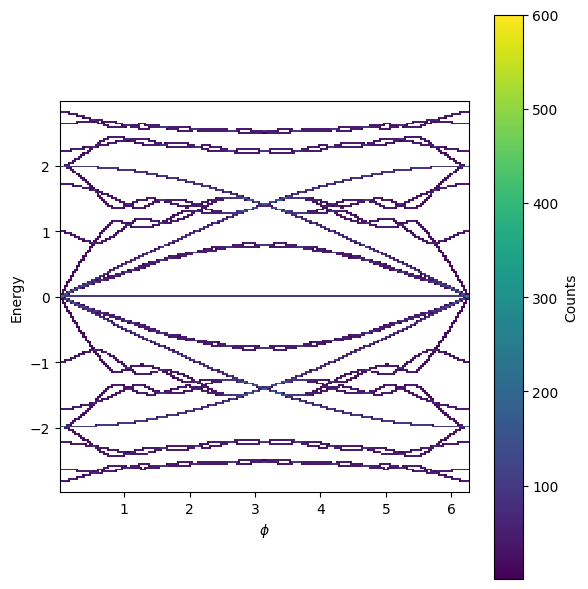

In [47]:
n=50
fig, ax = plot_binned_counters_heatmap(np.array(binned_counters).T, phis, energy_bins,vmax=n*np.max(binned_counters),rebin_factor=n)
plt.title("")
plt.show()

In [13]:
half_binned = []

for binned_counter in binned_counters:
    half_binned.append(binned_counter[int(Nbin/2):])

In [200]:
binned_counter

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
        2.,  0.,  4.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  0., 16.,  0.,
        0.,  0.,  2.,  0.,  0.,  0.,  0., 34.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., 74.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
        0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  4.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 42.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
        0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.,
        0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., 74.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 34.,  0.,
        0.,  0.,  0.,  2.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0

In [201]:
energy_bins[int(Nbin/2):]

array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ,
       0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.51, 0.54, 0.57, 0.6 , 0.63,
       0.66, 0.69, 0.72, 0.75, 0.78, 0.81, 0.84, 0.87, 0.9 , 0.93, 0.96,
       0.99, 1.02, 1.05, 1.08, 1.11, 1.14, 1.17, 1.2 , 1.23, 1.26, 1.29,
       1.32, 1.35, 1.38, 1.41, 1.44, 1.47, 1.5 , 1.53, 1.56, 1.59, 1.62,
       1.65, 1.68, 1.71, 1.74, 1.77, 1.8 , 1.83, 1.86, 1.89, 1.92, 1.95,
       1.98, 2.01, 2.04, 2.07, 2.1 , 2.13, 2.16, 2.19, 2.22, 2.25, 2.28,
       2.31, 2.34, 2.37, 2.4 , 2.43, 2.46, 2.49, 2.52, 2.55, 2.58, 2.61,
       2.64, 2.67, 2.7 , 2.73, 2.76, 2.79, 2.82, 2.85, 2.88, 2.91, 2.94,
       2.97, 3.  ])

In [206]:
bin_arr = np.array(binned_counters)


num_to_plot = []
for phi_idx,phi in enumerate(phis):
    for e_idx, energy in enumerate(energy_bins[int(Nbin/2):]):
        if bin_arr[phi_idx, e_idx+int(Nbin/2)-1] != 0:
            num_to_plot.append(np.round(energy*np.exp(1j*phi),decimals=4))

In [207]:
def plot_complex(z_array, annotate=False, **scatter_kwargs):
    """
    Scatter-plots an array-like of complex numbers on the complex plane.

    Parameters
    ----------
    z_array : array-like
        Iterable containing complex numbers.
    annotate : bool, optional
        If True, label each point with its index in the array.  Default False.
    scatter_kwargs : dict
        Extra kwargs forwarded to `plt.scatter`, e.g. marker='x', s=50.
    """
    z = np.asarray(z_array, dtype=np.complex128)

    fig, ax = plt.subplots()
    ax.scatter(z.real, z.imag, **scatter_kwargs)

    if annotate:
        for idx, val in enumerate(z):
            ax.annotate(str(idx), (val.real, val.imag),
                        textcoords="offset points", xytext=(5, 5))

    # Axes through the origin for reference
    ax.axhline(0, linewidth=0.8)
    ax.axvline(0, linewidth=0.8)

    #ax.set_xlabel("Real")
    #ax.set_ylabel("Imaginary")
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.set_title("d=7")
    plt.tight_layout()
    plt.show()

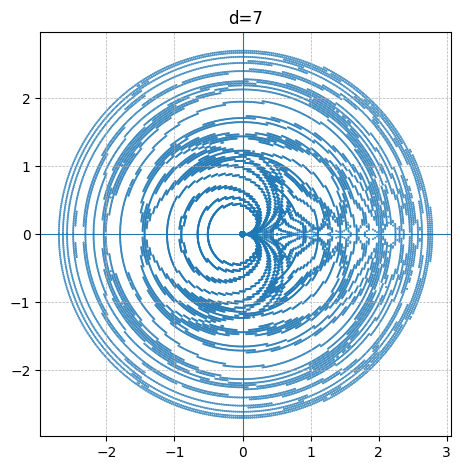

In [208]:
plot_complex(num_to_plot, s=[.2]*len(num_to_plot))

In [220]:
import numpy as np
import matplotlib.pyplot as plt

def hexbin_complex(z_array, gridsize=30, background="white", annotate=False,
                   **hexbin_kwargs):
    """
    2-D hex-bin histogram of complex numbers.

    Parameters
    ----------
    z_array : array-like
        Iterable of complex numbers to be plotted.
    gridsize : int or (int,int), optional
        Controls hexagon resolution (default 30).
    background : str, optional
        RGB/HTML color for empty bins (default "white").
    annotate : bool, optional
        Annotate the most populated hexagon with its count.
    hexbin_kwargs : dict
        Extra kwargs passed straight to `plt.hexbin`
        (e.g. bins='log', linewidths=0.3).
    """
    z = np.asarray(z_array, dtype=np.complex128)

    # Copy a colormap and make “count = 0” hexagons use the background color
    cmap = plt.cm.viridis.copy()
    cmap.set_under(background)

    hb = plt.hexbin(z.real, z.imag,
                    gridsize=gridsize,
                    cmap=cmap,
                    mincnt=1,         # do not draw hexagons with <1 count
                    **hexbin_kwargs)

    # Axes styling
    ax = plt.gca()
    ax.axhline(0, linewidth=0.8)
    ax.axvline(0, linewidth=0.8)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")

    # Colorbar: counts per hexagon
    cb = plt.colorbar(hb, label="Counts")

    if annotate:
        # Mark the hexagon with the largest occupancy
        counts = hb.get_array()
        if len(counts):
            idx = counts.argmax()
            x_centers, y_centers = hb.get_offsets().T
            ax.annotate(f"{int(counts[idx])}",
                        (x_centers[idx], y_centers[idx]),
                        xytext=(0, 5), textcoords="offset points",
                        ha="center")

    plt.tight_layout()
    plt.show()


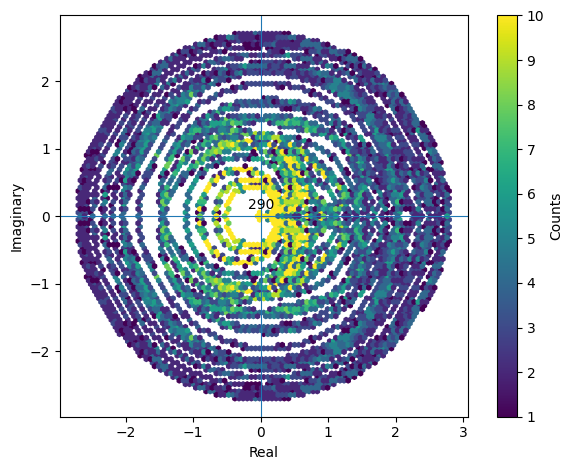

In [229]:
hexbin_complex(num_to_plot, gridsize=90, bins=None, annotate=True, vmax=10)
